In [26]:
# HUGE shout out to https://www.kaggle.com/headsortails/pytanic for the guide. Extremely in depth feature decomposition
#%matplotlib inline

# for seaborn issue:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from scipy import stats
import sklearn as sk
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import svm
import xgboost as xgb
from mlxtend.classifier import StackingClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

sns.set(style='white', context='notebook', palette='deep')

In [27]:
# initialize data
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
combine = pd.concat([train.drop('Survived',1),test])

In [28]:
# Percentage of people that survived?
surv = train[train['Survived']==1]
nosurv = train[train['Survived']==0]
surv_col = "blue"
nosurv_col = "red"

print("Survived: %i (%.1f percent), Not Survived: %i (%.1f percent), Total: %i"\
      %(len(surv), 1.*len(surv)/len(train)*100.0,\
        len(nosurv), 1.*len(nosurv)/len(train)*100.0, len(train)))

Survived: 342 (38.4 percent), Not Survived: 549 (61.6 percent), Total: 891


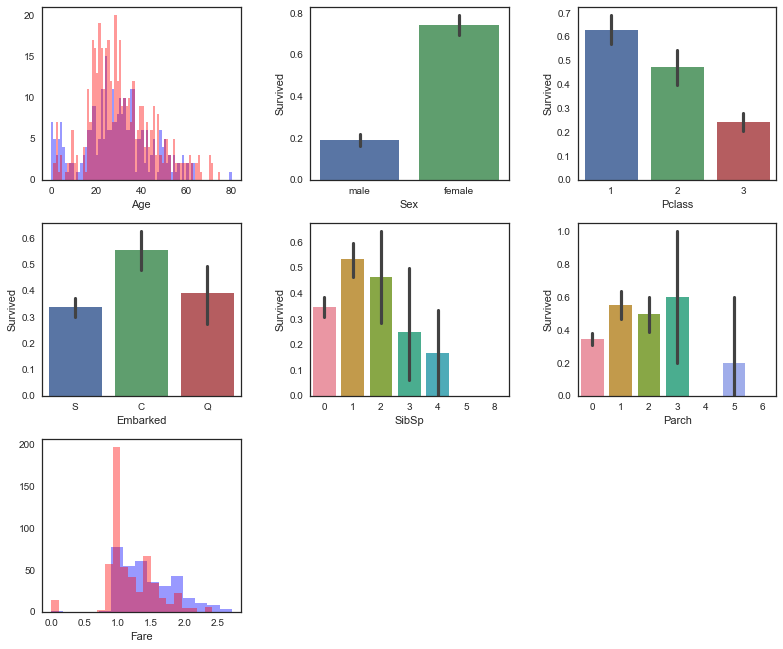

In [29]:
plt.figure(figsize=[12,10])
plt.subplot(331)
sns.distplot(surv['Age'].dropna().values, bins=range(0, 81, 1), kde=False, color=surv_col)
sns.distplot(nosurv['Age'].dropna().values, bins=range(0, 81, 1), kde=False, color=nosurv_col,
            axlabel='Age')
plt.subplot(332)
sns.barplot('Sex', 'Survived', data=train)
plt.subplot(333)
sns.barplot('Pclass', 'Survived', data=train)
plt.subplot(334)
sns.barplot('Embarked', 'Survived', data=train)
plt.subplot(335)
sns.barplot('SibSp', 'Survived', data=train)
plt.subplot(336)
sns.barplot('Parch', 'Survived', data=train)
plt.subplot(337)
sns.distplot(np.log10(surv['Fare'].dropna().values+1), kde=False, color=surv_col)
sns.distplot(np.log10(nosurv['Fare'].dropna().values+1), kde=False, color=nosurv_col,axlabel='Fare')
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()

In [30]:
# Cabin numbers
train.loc[:,['Survived','Cabin']].dropna().head(8)


,Survived,Cabin
1,1,C85
3,1,C123
6,0,E46
10,1,G6
11,1,C103
21,1,D56
23,1,A6
27,0,C23 C25 C27


* I suppose one could take the starting letters, which might indicate specific decks on the ship, and use them as an additional classifier. But for less than 25% of cabins known this might not be very useful. We'll see.

* Also, given that so few cabin numbers are know it doesn't seem that there are good records of them. Therefore, one should assume that it's more likely to know someone's cabin number if they survived. Let's see about that in the derived features.

Why do some people have multiple cabin numbers? What does that mean?

In [31]:
# Ticket
(train['Ticket'].nunique(),train['Ticket'].count())

# Sharing a ticket is not uncommon? Maybe we could turn this in to a feature?

(681, 891)

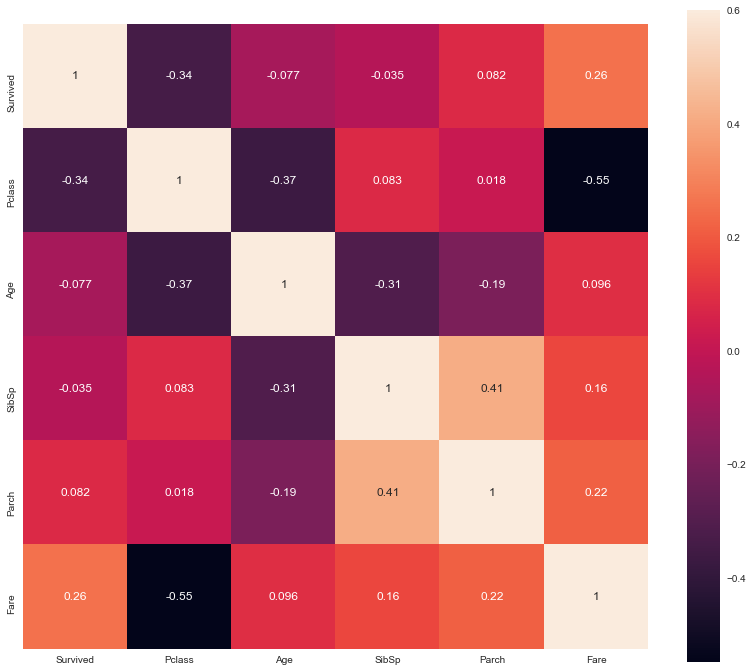

In [32]:
# RELATIONS BETWEEN FEATURES
plt.close()
plt.figure(figsize=(14,12))
foo = sns.heatmap(train.drop('PassengerId',axis=1).corr(), vmax=0.6, square=True, annot=True)
plt.show()

* Pclass is somewhat correlated with Fare (1st class tickets would be more expensive than 3rd class ones)
* SibSp and Parch are weakly correlated (large families would have high values for both; solo travellers would have zero for both)
* Pclass already correlates with Survived in a noticeable way

In [34]:
# filling in null values
print(train[train['Embarked'].isnull()])
train['Embarked'].iloc[61] = "C"
train['Embarked'].iloc[829] = "C"

     PassengerId  Survived  Pclass                                       Name  \
61            62         1       1                        Icard, Miss. Amelie   
829          830         1       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Ticket  Fare Cabin Embarked  
61   female  38.0      0      0  113572  80.0   B28      NaN  
829  female  62.0      0      0  113572  80.0   B28      NaN  


In [36]:
print(test[test['Fare'].isnull()])
test['Fare'].iloc[152] = combine['Fare'][combine['Pclass'] == 3].dropna().median()


     PassengerId  Pclass                Name   Sex   Age  SibSp  Parch Ticket  \
152         1044       3  Storey, Mr. Thomas  male  60.5      0      0   3701   

     Fare Cabin Embarked  
152   NaN   NaN        S  


In [37]:
combine = pd.concat([train.drop('Survived',1),test])
survived = train['Survived']

combine['Child'] = combine['Age']<=10
combine['Cabin_known'] = combine['Cabin'].isnull() == False
combine['Age_known'] = combine['Age'].isnull() == False
combine['Family'] = combine['SibSp'] + combine['Parch']
combine['Alone']  = (combine['SibSp'] + combine['Parch']) == 0
combine['Large_Family'] = (combine['SibSp']>2) | (combine['Parch']>3)
combine['Deck'] = combine['Cabin'].str[0]
combine['Deck'] = combine['Deck'].fillna(value='U')
combine['Ttype'] = combine['Ticket'].str[0]
combine['Title'] = combine['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
combine['Fare_cat'] = pd.DataFrame(np.floor(np.log10(combine['Fare'] + 1))).astype('int')
combine['Bad_ticket'] = combine['Ttype'].isin(['3','4','5','6','7','8','A','L','W'])
combine['Young'] = (combine['Age']<=30) | (combine['Title'].isin(['Master','Miss','Mlle']))
combine['Shared_ticket'] = np.where(combine.groupby('Ticket')['Name'].transform('count') > 1, 1, 0)
combine['Ticket_group'] = combine.groupby('Ticket')['Name'].transform('count')
combine['Fare_eff'] = combine['Fare']/combine['Ticket_group']
combine['Fare_eff_cat'] = np.where(combine['Fare_eff']>16.0, 2, 1)
combine['Fare_eff_cat'] = np.where(combine['Fare_eff']<8.5,0,combine['Fare_eff_cat'])
test = combine.iloc[len(train):]
train = combine.iloc[:len(train)]
train['Survived'] = survived

surv = train[train['Survived']==1]
nosurv = train[train['Survived']==0]

In [38]:
# mapping string values
combine = pd.concat([train.drop('Survived', 1), test])
survived = train['Survived']

combine["Sex"] = combine["Sex"].astype("category")
combine["Sex"].cat.categories = [0, 1]
combine["Sex"] = combine["Sex"].astype(int)

combine["Embarked"] = combine["Embarked"].astype("category")
combine["Embarked"].cat.categories = [0,1,2]
combine["Embarked"] = combine["Embarked"].astype("int")

combine["Deck"] = combine["Deck"].astype("category")
combine["Deck"].cat.categories = [0,1,2,3,4,5,6,7,8]
combine["Deck"] = combine["Deck"].astype("int")

test = combine.iloc[len(train):]
train = combine.iloc[:len(train)]
train['Survived'] = survived

train.loc[:,["Sex","Embarked"]].head()

,Sex,Embarked
0,1,2
1,0,0
2,0,2
3,0,2
4,1,2


In [51]:
training, testing = train_test_split(train, test_size=0.2, random_state=0)
print("Total sample size = %i; training sample size = %i, testing sample size = %i"\
     %(train.shape[0],training.shape[0],testing.shape[0]))
# test training split of our training data - best for avoiding overfitting


Total sample size = 891; training sample size = 712, testing sample size = 179


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Deck,Ttype,Title,Fare_cat,Bad_ticket,Young,Shared_ticket,Ticket_group,Fare_eff,Fare_eff_cat
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,NaN,...,8,3,Mr,0,True,False,0,1,7.829200,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,NaN,...,8,3,Mrs,0,True,False,0,1,7.000000,0
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,NaN,...,8,2,Mr,1,False,False,0,1,9.687500,1
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,NaN,...,8,3,Mr,0,True,True,0,1,8.662500,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,12.2875,NaN,...,8,3,Mrs,1,True,True,1,2,6.143750,0
5,897,3,"Svensson, Mr. Johan Cervin",1,14.0,0,0,7538,9.2250,NaN,...,8,7,Mr,1,True,True,0,1,9.225000,1
6,898,3,"Connolly, Miss. Kate",0,30.0,0,0,330972,7.6292,NaN,...,8,3,Miss,0,True,True,0,1,7.629200,0
7,899,2,"Caldwell, Mr. Albert Francis",1,26.0,1,1,248738,29.0000,NaN,...,8,2,Mr,1,False,True,1,3,9.666667,1
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",0,18.0,0,0,2657,7.2292,NaN,...,8,2,Mrs,0,False,True,0,1,7.229200,0
9,901,3,"Davies, Mr. John Samuel",1,21.0,2,0,A/4 48871,24.1500,NaN,...,8,A,Mr,1,True,True,1,3,8.050000,0


### Selecting features
This is an iterative process in which you improve your model step by step, until you have found the largest feature combination which still has significant impact. Removing less important features will help you to reduce the noise in your prediction and allow your model to generalise to new data (which is our priority goal in machine learning.)

In [56]:
cols = ['Sex','Pclass','Cabin_known','Large_Family','Shared_ticket','Young','Alone','Child']
tcols = np.append(['Survived'],cols)

# prepping our training set
df = training.loc[:,tcols].dropna()
X = df.loc[:, cols]
y = np.ravel(df.loc[:, ['Survived']])

# prepping our test set
df_test = testing.loc[:,tcols].dropna()
X_test = df_test.loc[:,cols]
y_test = np.ravel(df_test.loc[:,['Survived']])


,Sex,Pclass,Cabin_known,Large_Family,Shared_ticket,Young,Alone,Child
0,1,3,False,False,0,False,True,False
1,0,3,False,False,0,False,False,False
2,1,2,False,False,0,False,True,False
3,1,3,False,False,0,True,True,False
4,0,3,False,False,1,True,False,False
5,1,3,False,False,0,True,True,False
6,0,3,False,False,0,True,True,False
7,1,2,False,False,1,True,False,False
8,0,3,False,False,0,True,True,False
9,1,3,False,False,1,True,False,False


In [45]:
# Using an ensemble of classifiers together with VOTING

clf_knn = KNeighborsClassifier(n_neighbors=10,weights='distance')
clf_svm = svm.SVC(class_weight='balanced')
clf_ext = ExtraTreesClassifier(
    max_features='auto',
    bootstrap=True,
    oob_score=True,
    n_estimators=1000,
    max_depth=None,
    min_samples_split=10
    #class_weight="balanced",
    #min_weight_fraction_leaf=0.02
    )
clf_xgb = xgb.XGBClassifier(
    max_depth=2,
    n_estimators=500,
    subsample=0.5,
    learning_rate=0.1
    )
clf_pctr = Perceptron(class_weight='balanced')
clf_log = LogisticRegression()

clf_vote = VotingClassifier(
    estimators=[
        #('tree', clf_tree),
        ('knn', clf_knn),
        ('svm', clf_svm),
        ('extra', clf_ext),
       #('gb', clf_gb),
        ('xgb', clf_xgb),
        ('percep', clf_pctr),
        ('logistic', clf_log),
        #('RF', clf_rf),
        ],
    weights=[2,2,3,3,1,2],
    voting='hard')

clf_vote.fit(X,y)

VotingClassifier(estimators=[('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='distance')), ('svm', SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='hard',
         weights=[2, 2, 3, 3, 1, 2])

Each individual classifier makes a certain prediction and then the majority vote is used for each row. This majority process can either give all individual votes the same importance or assign different weights to make some classifiers have more impact than others.

In [48]:
scores = cross_val_score(clf_vote, X, y, cv=5, scoring='accuracy')
print("Voting: Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

Voting: Accuracy: 0.82 (+/- 0.02)


In [59]:
df = test.loc[:,cols].dropna()
X_test = df.loc[:, cols]

res = clf_vote.predict(X_test)
df_result = pd.DataFrame()
df_result["PassengerId"] = test["PassengerId"]
df_result["Survived"] = res.ravel()
df_result.to_csv("results.csv", sep=",", index=False)
